## WordEmbedding-based model implementation

In [4]:
import torch

In [2]:
if torch.backends.mps.is_built():
    print("PyTorch is built with MPS")
else:
    print("MPS not available.")


PyTorch is built with MPS


In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print("MPS device not found") 

In [5]:
#torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)

cpu
cpu


In [5]:
import sys
sys.version

'3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]'

In [6]:
import platform
platform.architecture()


('64bit', '')

## PRE-PROCESSING

In [1]:
# Basic utilities
import os
import platform

# Data handling and manipulation
import numpy as np
import pandas as pd
import ast

# Text preprocessing and sentiment analysis utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities for model evaluation and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, classification_report)

import fasttext

In [8]:
def general_info():
    print("Machine:", platform.machine())
    print("Platform:", platform.platform())
    print("Mac Version:", platform.mac_ver())
    print("Processor:", platform.processor())
    print("Python Version:", platform.python_version())
  
general_info()

Machine: x86_64
Platform: macOS-10.16-x86_64-i386-64bit
Mac Version: ('10.16', ('', '', ''), 'x86_64')
Processor: i386
Python Version: 3.9.12


In [9]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.2.0
ipykernel        : 6.9.1
ipywidgets       : 7.6.5
jupyter_client   : 6.1.12
jupyter_core     : 4.9.2
jupyter_server   : 1.13.5
jupyterlab       : 3.3.2
nbclient         : 0.5.13
nbconvert        : 6.4.4
nbformat         : 5.3.0
notebook         : 6.4.8
qtconsole        : 5.3.0
traitlets        : 5.1.1


In [10]:
# Specify the path to the dataset, load the csv into Pandas DataFrame
data_pth = '/users/anshulvij/Desktop/Masters Project/Datasets/SEntFiN-v1.1.csv'
df = pd.read_csv(data_pth)
df

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8
...,...,...,...,...
10748,10749,"Negative on Chambal, Advanta: Mitesh Thacker","{""Chambal"": ""negative"", ""Advanta"": ""negative""}",6
10749,10750,"Small, Mid-cap stocks may emerge outperformers","{""Small"": ""positive"", ""Mid-cap stocks"": ""posit...",6
10750,10751,Rupee slips against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5
10751,10752,Rupee weak against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5


#### PRE-PROCESSING STEPS IMPLEMENTED BELOW:-

In [11]:
def filter_rows_by_colon_count(data, column):
    """
    Filters out rows where the count of colons in the specified column exceeds one.

    Parameters:
    - data (pd.DataFrame): The DataFrame to be processed.
    - column (str): The column name in which colon count needs to be checked.

    Returns:
    - pd.DataFrame: DataFrame after filtering out specific rows.
    """
    condition = data[column].apply(lambda entry: str(entry).count(':') > 1)
    return data[~condition]

In [12]:
df = filter_rows_by_colon_count(df, 'Decisions')
print(f"Post Filtering Stage-1 Step-1: Total Rows - {len(df)}")

Post Filtering Stage-1 Step-1: Total Rows - 7903


In [13]:
def transform_decision_data(data, column):
    """
    Transforms the specified column of the DataFrame by extracting 'Entity' and 'Polarity' 
    from a dictionary representation. Ensures that strings mimicking dictionaries are 
    converted to actual dictionaries.

    Parameters:
    - data (pd.DataFrame): The DataFrame to be processed.
    - column (str): The column name which contains dictionary or its string representation.

    Returns:
    - pd.DataFrame: Transformed DataFrame with 'Headlines', 'Entity', and 'Sentiment' columns.
    """
    data_copy = data.copy()
    
    # Convert string representation of dictionary to actual dictionary
    data_copy[column] = data_copy[column].apply(lambda item: ast.literal_eval(item) if isinstance(item, str) else item)
    
    # Extract key and value from the dictionary
    data_copy['Entity'] = data_copy[column].apply(lambda item: list(item.keys())[0] if isinstance(item, dict) else None)
    data_copy['Sentiment'] = data_copy[column].apply(lambda item: list(item.values())[0] if isinstance(item, dict) else None)
    
    return data_copy[['Title', 'Entity', 'Sentiment']].rename(columns={'Title': 'Headlines'})

processed_df = transform_decision_data(df, 'Decisions')

#Dropping the entity column as the rest have been set aside in the transform_decision_data
processed_df = processed_df.drop(columns=['Entity'])


print(f"Post Filtering Stage-1 Step-2: Total Rows - {len(processed_df)}")

Post Filtering Stage-1 Step-2: Total Rows - 7903


In [14]:
def check_missing_data(dataframe):
    """
    Checks and returns the number of missing values in each column of a DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to be checked.

    Returns:
    - Series: Number of missing values for each column.
    """
    return dataframe.isnull().sum()

print("Missing Values:\n", check_missing_data(processed_df))
processed_df = processed_df.dropna()
print(f"Post Filtering Stage-2 Step-1: Total Rows - {len(processed_df)}")

Missing Values:
 Headlines    0
Sentiment    0
dtype: int64
Post Filtering Stage-2 Step-1: Total Rows - 7903


In [15]:
def refine_headlines(column):
    """
    Cleans and refines a given text column. The function lowercases the text, removes 
    HTML content, URLs, non-alphanumeric characters, and stopwords. It also lemmatises 
    each word for better text consistency.

    Parameters:
    - column (pd.Series): The column containing text data to be refined.

    Returns:
    - pd.Series: The refined column.
    """
    column = column.str.lower()
    
    # Check if text looks like filename or not
    def extract_text(text):
        if re.match(r'^[A-Za-z0-9_\-\.]+$', text):
            return text
        return BeautifulSoup(text, 'lxml').get_text()
    
    column = column.str.replace('http\S+|www.\S+|[^\w\s]', '', regex=True)
    
   # lemmatizer = WordNetLemmatizer()
   # stop_words = set(stopwords.words('english'))
   # column = column.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))
    
    return column

processed_df['Headlines'] = refine_headlines(processed_df['Headlines'])
print(f"Post Filtering Stage-2 Step-2: Total Rows - {len(processed_df)}")


Post Filtering Stage-2 Step-2: Total Rows - 7903


In [16]:
# Detect and remove duplicate rows from the DataFrame
duplicated_rows = processed_df[processed_df.duplicated()]
processed_df.drop_duplicates(inplace=True)
print(f"Post Filtering Stage-2 Step-3 Total Rows - {len(processed_df)}")


Post Filtering Stage-2 Step-3 Total Rows - 7858


In [17]:
def display_sentiment_counts(dataframe, column_name='Sentiment'):
    """
    Displays the frequency and relative percentage of each sentiment value in the given DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing sentiment data.
    - column_name (str, optional): The name of the column containing sentiment values. Default is 'Sentiment'.

    Prints:
    - Sentiment counts and their relative percentages.
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(processed_df)



Count of each sentiment:
positive    2830
neutral     2657
negative    2371
Name: Sentiment, dtype: int64
positive    36.014253
neutral     33.812675
negative    30.173072
Name: Sentiment, dtype: float64


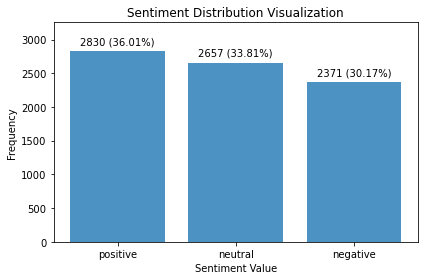

In [18]:
# Calculate and visualize the distribution of sentiment values in the DataFrame using a bar chart.
# Each bar is labelled with the sentiment count and its relative percentage.

# Calculate sentiment frequency and its relative percentage
sentiment_frequency = processed_df['Sentiment'].value_counts()
sentiment_ratio = processed_df['Sentiment'].value_counts(normalize=True) * 100

# Display sentiment distribution using a bar chart
bars = plt.bar(sentiment_frequency.index, sentiment_frequency.values, alpha=0.8)

# Adjust the y-axis limit
plt.ylim(0, max(sentiment_frequency.values) * 1.15)  # Increase the upper limit by 15% of the highest bar value

# Label each bar with the sentiment count and its percentage
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    sentiment_label = sentiment_frequency.index[idx]
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(sentiment_frequency.values) * 0.05, 
             f'{int(yval)} ({sentiment_ratio[sentiment_label]:.2f}%)',
             ha='center', va='center')

plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution Visualization')
plt.tight_layout()
plt.show()

FASTText Implementation

In [19]:
def fasttext_format(df):
    """
    Converts the sentiment column to the '__label__' format that FastText requires.
    
    Parameters:
    - df (DataFrame): Dataframe with the 'Sentiment' column to be converted.
    
    Returns:
    DataFrame: Dataframe with modified 'Sentiment' column.
    """
    df['Sentiment'] = '__label__' + df['Sentiment'].astype(str)
    return df

In [20]:
def save_to_txt(dataframes, filenames):
    """
    Save dataframes to txt format.
    
    Parameters:
    - dataframes (list): List of dataframes to be saved.
    - filenames (list): List of filenames to save the dataframes as.
    
    Returns:
    None
    """
    for subset, name in zip(dataframes, filenames):
        subset[['Headlines', 'Sentiment']].to_csv(f'{name}.txt', index=False, sep=' ', header=None)


In [21]:
def fasttext_hyperparameter_autotune(train_file, val_file, duration):
    """
    Train FastText supervised model with autotuning on given train and validation files.
    
    Parameters:
    - train_file (str): Path to the training dataset.
    - val_file (str): Path to the validation dataset.
    - duration (int): Duration in seconds for the autotune process.
    
    Returns:
    FastText model
    """
    return fasttext.train_supervised(
        input=train_file,
        autotuneValidationFile=val_file,
        autotuneDuration=duration
    )

In [22]:
def display_report(data_df, model, set_name="Data"):
    """
    Evaluate a FastText model on the given data.
    
    Parameters:
    - data_df (DataFrame): Data to be evaluated on.
    - model (FastText model): Model for evaluation.
    - set_name (str, optional): Name for the data set being evaluated.
    
    Returns:
    None
    """
    labels = data_df['Sentiment'].str.replace('__label__', '').tolist()
    sentences = data_df['Headlines'].tolist()
    preds = [model.predict(x)[0][0].replace('__label__', '') for x in sentences]

    # Printing classification report
    report = classification_report(labels, preds, labels=["positive", "negative", "neutral"], digits =4)
    print(f'{set_name} Classification Report:\n')
    print(report)

    # Plotting the confusion matrix
    conf_mat = confusion_matrix(labels, preds, labels=["positive", "negative", "neutral"])
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{set_name} Confusion matrix')
    plt.show()
    

In [4]:
def compute_FPR_spec_metrics(cm, labels=["positive", "negative", "neutral"]):
    """
    Compute specificity, FPR, precision for each class, and the overall accuracy given a 3x3 confusion matrix.
    Also, computes weighted and macro average for FPR and specificity.

    Args:
    - cm (numpy array): 3x3 confusion matrix
    - labels (list): List of class labels in order

    Returns:
    None. It will print the results directly.
    """
    
    specificities = []
    fprs = []
    precisions = []

    for i in range(3):
        tp = cm[i, i]
        tn = sum(cm[j, j] for j in range(3) if j != i)
        fp = sum(cm[j, i] for j in range(3) if j != i)
        fn = sum(cm[i, j] for j in range(3) if j != i)
        
        specificity = tn / (tn + fp) if tn + fp != 0 else 0
        fpr = 1 - specificity
        precision = tp / (tp + fp) if tp + fp != 0 else 0
        
        specificities.append(round(specificity, 4))
        fprs.append(round(fpr, 4))
        precisions.append(round(precision, 4))
    
    # Print the class values with their corresponding metrics
    for i, label in enumerate(labels):
        print(f"Metrics for class {label} (Class value: {i}):")
        print(f"Specificity: {specificities[i]}")
        print(f"FPR: {fprs[i]}")
        print(f"Precision: {precisions[i]}\n")

    # Calculate overall accuracy
    accuracy = round(np.trace(cm) / np.sum(cm), 4)
    print(f"Overall accuracy: {accuracy}")

    # Calculate true values for each class for weighting purposes
    true_values = np.sum(cm, axis=1)
    total_true_values = np.sum(true_values)

    # Calculate weighted average specificity and FPR
    weighted_avg_spec = round(sum(specificities[i] * true_values[i] for i in range(3)) / total_true_values, 4)
    weighted_avg_fpr = round(sum(fprs[i] * true_values[i] for i in range(3)) / total_true_values, 4)

    # Calculate macro average specificity and FPR
    macro_avg_spec = round(np.mean(specificities), 4)
    macro_avg_fpr = round(np.mean(fprs), 4)

    print(f"Weighted average specificity: {weighted_avg_spec}")
    print(f"Weighted average FPR: {weighted_avg_fpr}")
    print(f"Macro average specificity: {macro_avg_spec}")
    print(f"Macro average FPR: {macro_avg_fpr}\n")


In [23]:
def display_sentences(data_df, model):
    """
    Print the sentences that were misclassified by the model.
    
    Parameters:
    - data_df (DataFrame): Data with actual labels and sentences.
    - model (FastText model): Model used for predictions.
    
    Returns:
    None
    """
    labels = data_df['Sentiment'].str.replace('__label__', '').tolist()
    sentences = data_df['Headlines'].tolist()
    preds = [model.predict(x)[0][0].replace('__label__', '') for x in sentences]

    print("\nMisclassified Sentences:\n")
    for actual, pred, sent in zip(labels, preds, sentences):
        if actual != pred:
            print(f"Actual: {actual}, Predicted: {pred}, Headlines: {sent}")


In [24]:
# Converting to FastText format
processed_df = fasttext_format(processed_df)

# Splitting the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(processed_df, test_size=0.3, random_state=5)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=5)

# Saving datasets to txt format
save_to_txt([train_df, val_df, test_df], ['train', 'val', 'test'])

Progress: 100.0% Trials: 4517 Best score:  0.808312 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  10383
Number of labels: 3
Progress: 100.0% words/sec/thread:  247149 lr:  0.000000 avg.loss:  0.599868 ETA:   0h 0m 0s


Evaluating with obtained hyperparameters: <fasttext_pybind.args object at 0x7f9ff4102930>
Validation Classification Report:

              precision    recall  f1-score   support

    positive     0.8175    0.8155    0.8165       412
    negative     0.8044    0.7871    0.7956       371
     neutral     0.7407    0.7576    0.7491       396

    accuracy                         0.7871      1179
   macro avg     0.7876    0.7867    0.7871      1179
weighted avg     0.7876    0.7871    0.7873      1179



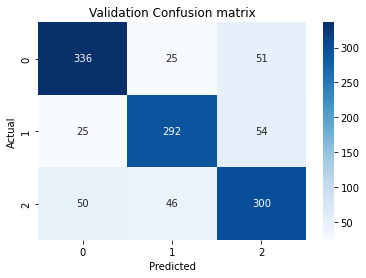

Test Classification Report:

              precision    recall  f1-score   support

    positive     0.8611    0.7803    0.8187       437
    negative     0.8295    0.8130    0.8212       353
     neutral     0.7414    0.8329    0.7845       389

    accuracy                         0.8075      1179
   macro avg     0.8107    0.8088    0.8081      1179
weighted avg     0.8121    0.8075    0.8082      1179



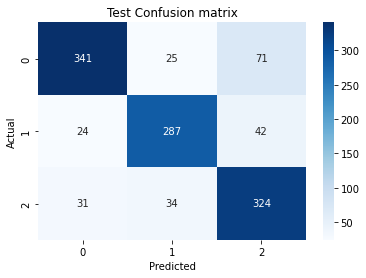

In [25]:
# Train with autotune
model = fasttext_hyperparameter_autotune('train.txt', 'val.txt', 1200)
hyperparameters = model.f.getArgs()
print(f"Evaluating with obtained hyperparameters: {hyperparameters}")

display_report(val_df, model, "Validation")
display_report(test_df, model, "Test")

In [5]:
#Manually enter the matrix to get results about the specificity and FPR
#(These values can change as Fasttext will go through autotuning the parameters and the result might differ)
cm = np.array([[341, 25, 71], 
               [24, 287, 42], 
               [31, 34, 324]])

compute_FPR_spec_metrics(cm)

Metrics for class positive (Class value: 0):
Specificity: 0.9174
FPR: 0.0826
Precision: 0.8611

Metrics for class negative (Class value: 1):
Specificity: 0.9185
FPR: 0.0815
Precision: 0.8295

Metrics for class neutral (Class value: 2):
Specificity: 0.8475
FPR: 0.1525
Precision: 0.7414

Overall accuracy: 0.8075
Weighted average specificity: 0.8947
Weighted average FPR: 0.1053
Macro average specificity: 0.8945
Macro average FPR: 0.1055



In [26]:
print("The hyperparameters after autotuning:-")
print("Learning rate:", hyperparameters.lr)
print("Dimension:", hyperparameters.dim)
print("Epoch:", hyperparameters.epoch)

The hyperparameters after autotuning:-
Learning rate: 1.046168689725122
Dimension: 5
Epoch: 3


In [27]:
# Print misclassified sentences
display_sentences(val_df, model)
display_sentences(test_df, model)


Misclassified Sentences:

Actual: neutral, Predicted: positive, Headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: negative, Headlines: 6150 on the nifty looks a matter of time ashwani gujral
Actual: positive, Predicted: neutral, Headlines: cerc order a new lease of life for adani power clsa
Actual: neutral, Predicted: negative, Headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: negative, Predicted: neutral, Headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: positive, Headlines: bonds retreats on fresh selling call rates recover
Actual: negative, Predicted: positive, Headlines: saintgobain sees big selloff post plans to merge grindwell norton
Actual: negative, Predicted: neutral, Headlines: hardening rupee fails to attract nris to invest in india
Actual: positive, Predicted: neutral, Headlines: like zee entertainment in medi

In [28]:
model.save_model("model_fasttext.bin")

In [29]:
print(model.words)
print(model.labels)

['</s>', 'to', 'on', 'rs', 'in', 'net', 'of', 'at', 'for', 'as', 'up', 'crore"', 'a', 'profit', 'stocks', 'the', 'per', 'shares', 'over', 'stock', 'india', 'futures', 'cent', 'may', 'crore', 'q1', 'down', 'by', 'with', 'q2', 'bank', 'q3', 'from', 'q4', 'is', 'market', 'after', 'nifty', 'ashwani', 'new', 'be', 'loss', 'pc', 'high', 'global', 'gujral"', 'and', 'cr"', 'demand"', 'fall', 'mitesh', 'thacker"', 'markets', 'it', 'prices', 'ipo', 'oil', 'investors', 'us', 'likely', 'rises', 'falls', 'low', 'will', 'cr', 'not', 'weak', 'hits', 'buy', 'appoints', 'raise', '"sebi', 'rallies', 'top', 'good', 'target', 'demand', 'ahead', 'industries', 'post', 'growth', 'hit', 'price', 'companies', 'pharma', 'jumps', 'slips', 'posts', 'levels', 'surges', 'deepak', 'gains', 'can', '5', 'bond', 'results"', 'ltd', 'cues"', 'strong', 'seen', 'trading', '10', 'sector', '"gold', 'near', 'plans', 'rally', '"sell', 'stake', 'more', 'results', 'flat', 'financial', 'reports', '20', 'rise', 'gold', 'higher', '

In [30]:
model = fasttext.load_model("model_fasttext.bin")

In [31]:
print(model.words)

['</s>', 'to', 'on', 'rs', 'in', 'net', 'of', 'at', 'for', 'as', 'up', 'crore"', 'a', 'profit', 'stocks', 'the', 'per', 'shares', 'over', 'stock', 'india', 'futures', 'cent', 'may', 'crore', 'q1', 'down', 'by', 'with', 'q2', 'bank', 'q3', 'from', 'q4', 'is', 'market', 'after', 'nifty', 'ashwani', 'new', 'be', 'loss', 'pc', 'high', 'global', 'gujral"', 'and', 'cr"', 'demand"', 'fall', 'mitesh', 'thacker"', 'markets', 'it', 'prices', 'ipo', 'oil', 'investors', 'us', 'likely', 'rises', 'falls', 'low', 'will', 'cr', 'not', 'weak', 'hits', 'buy', 'appoints', 'raise', '"sebi', 'rallies', 'top', 'good', 'target', 'demand', 'ahead', 'industries', 'post', 'growth', 'hit', 'price', 'companies', 'pharma', 'jumps', 'slips', 'posts', 'levels', 'surges', 'deepak', 'gains', 'can', '5', 'bond', 'results"', 'ltd', 'cues"', 'strong', 'seen', 'trading', '10', 'sector', '"gold', 'near', 'plans', 'rally', '"sell', 'stake', 'more', 'results', 'flat', 'financial', 'reports', '20', 'rise', 'gold', 'higher', '